In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from pysap.data import get_sample_data
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Lower level imports
from algo.prox import prox_G,prox_F1_dual,prox_F2_dual
from algo.pdhg import pdhg
from algo.cost_utils import *

#Upper level imports
from scipy.sparse.linalg import cg,LinearOperator
import scipy
import time
from algo.upper_level_utils import *
from scipy.optimize.lbfgsb import fmin_l_bfgs_b

In [3]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data[125:175,125:175]

In [4]:
n=u0_mat.shape[0]
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0_mat.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0_mat.shape,implementation='cpu')

y = (1+0j)*fourier_op.op(u0_mat)+1e-7*np.random.randn(2*n*n).view(np.complex128)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [5]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
radial_p = np.zeros((n*n+1,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
radial_p[n*ind1+ind2]=1
radial_p[-1]=1e-6
p = np.copy(radial_p)

#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=4,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

param = {"pn1":p[-1],"epsilon":1e-5,"gamma":1e-10}


In [13]:
pysap.Image(data=np.reshape(radial_p[:-1],(n,n))).show()

In [16]:
print(ssim(fourier_op.adj_op(p[:-1]*y),u0_mat))
pysap.Image(data=fourier_op.adj_op(p[:-1]*y)).show()

0.986610399009073


# Definition of functions
Only for one linear operator for the moment (wavelet).

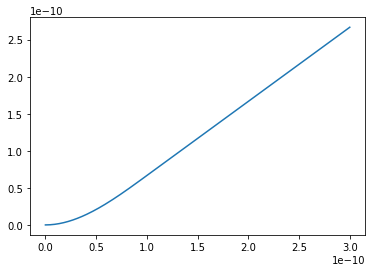

In [17]:
x = np.linspace(0,3*param["gamma"],200)
plt.plot(x,rho_vec(x,param["gamma"]))

In [18]:
psix_vec(np.array([1+1j]),1e-10)

array([-0.35355339-0.35355339j])

# Functions and first order derivatives

In [19]:
#Base functions
def Eeps(x,p):return param["epsilon"]/2*np.linalg.norm(x)**2
def Edata(x,p):return 0.5*np.linalg.norm(p[:-1]**2*(fourier_op.op(x)-y))**2
def Ereg(x,p):return p[-1]*np.sum(rho_vec(np.abs(linear_op.op(x)),param["gamma"]))
def Etot(x,p):return Eeps(x,p)+Edata(x,p)+Ereg(x,p)

#First order derivatives
def Du_Eeps(x,p):return param["epsilon"]*x
def Du_Edata(x,p):return fourier_op.adj_op(p[:-1]*(fourier_op.op(x)-y))
def Du_Ereg(x,p):
    lin_x = linear_op.op(x)
    return p[-1]*linear_op.adj_op(phi_vec(np.abs(lin_x),param["gamma"])*lin_x)
def Du_Etot(x,p):return Du_Eeps(x,p)+Du_Edata(x,p)+Du_Ereg(x,p)

### Numerical check
Plots of $\left|\frac{f(a+th)-f(a)-<\nabla f(a),th>}{t}\right|$ for $t\rightarrow 0$.

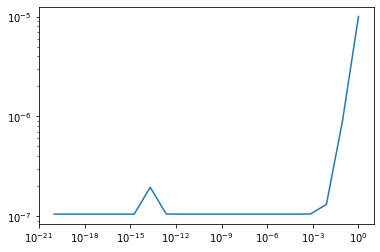

In [35]:
# -- Eeps --
#Two random vectors with same amplitude
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n

tests = np.logspace(-20,0,20)
real_values = np.array([Eeps(a+t*a2,radial_p) for t in tests])
approx = np.array([Eeps(a,radial_p)+np.sum(Du_Eeps(a,radial_p)*np.conj(t*a2)) for t in tests])

plt.plot(tests,np.abs((real_values-approx)/tests))
plt.xscale("log")
plt.yscale("log")

In [21]:
real_values[0],approx[0]

(4.623565640974052e-06, 4.623565640974052e-06)

1.9219769926101796e-11


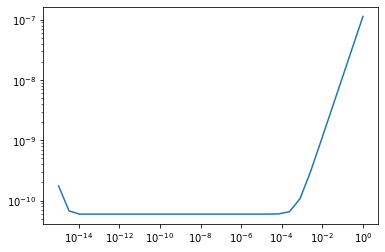

In [12]:
# -- Edata --
#Random vector with same amplitude as u0
a = u0_mat
#a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n*n).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

p=radial_p
tests = np.logspace(-15,0,30)
real_values = np.array([Edata(a+t*a2,p) for t in tests])
approx = np.array([Edata(a,p)+t*np.sum(Du_Edata(a,radial_p)*np.conj(a2)) for t in tests])

print(Edata(a,radial_p))
plt.plot(tests,np.abs((real_values-approx)/tests))
plt.xscale("log")
plt.yscale("log")

In [13]:
real_values[0],approx[0]

(1.9219769926101958e-11, (1.9219769926101793e-11+5.966272569657413e-26j))

/home/guillaume/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


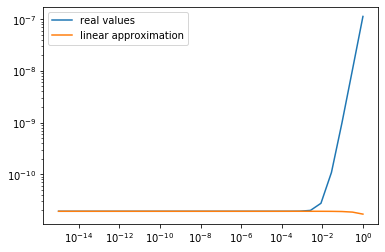

In [14]:
plt.plot(tests,real_values,label="real values")
plt.plot(tests,approx,label="linear approximation")
plt.xscale("log")
plt.yscale("log")
plt.legend()

2.539352882852719


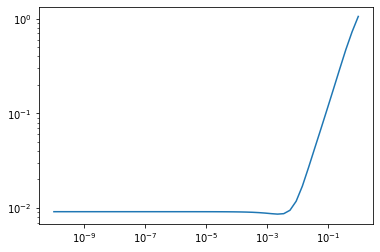

In [28]:
# -- Ereg --
#Random vector with same amplitude as u0
a = np.random.randn(2*n*n).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
#a=u0_mat
a2 = np.random.randn(2*n*n).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

tests = np.logspace(-10,0,50)
real_values = np.array([Ereg(a+t*a2,radial_p) for t in tests])
approx = np.array([Ereg(a,radial_p)+np.sum(Du_Ereg(a,radial_p)*np.conj(t*a2)) for t in tests])

print(Ereg(a,radial_p))
plt.plot(tests,np.abs((real_values-approx)/tests))
plt.xscale("log")
plt.yscale("log")

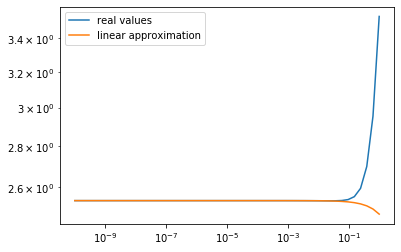

In [30]:
plt.plot(tests,real_values,label="real values")
plt.plot(tests,approx,label="linear approximation")
plt.xscale("log")
plt.yscale("log")
plt.legend()

2.086511025385618e-07


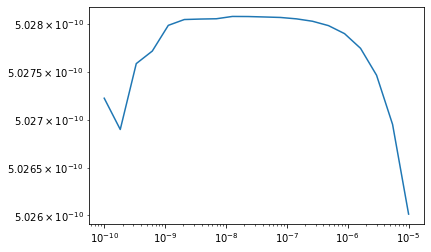

In [173]:
# -- Etot --
#Random vector with same amplitude as u0
a = np.random.randn(2*n*n).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n*n).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
#a=u0_mat

tests = np.logspace(-10,-5,20)
real_values = np.array([Etot(a+t*a2,radial_p) for t in tests])
approx = np.array([Etot(a,radial_p)+np.sum(Du_Etot(a,radial_p)*np.conj(t*a2))for t in tests])

print(Etot(a,radial_p))
plt.plot(tests,np.abs((real_values-approx)/tests))
plt.xscale("log")
plt.yscale("log")

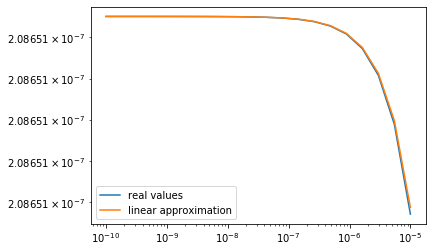

In [174]:
plt.plot(tests,real_values,label="real values")
plt.plot(tests,approx,label="linear approximation")
plt.xscale("log")
plt.yscale("log")
plt.legend()

# Second order derivatives
We don't express the hessians as matrices but as linear operators. Same verifications: $\frac{||\nabla f(a+th)-(\nabla f(a)+t\nabla^2f(a)h)||_2}{t}$.

In [75]:
def Du2_Eeps(u,p,w):return param["epsilon"]*w
def Du2_Edata(u,p,w):return fourier_op.adj_op(p[:-1]**2*fourier_op.op(w))
def Du2_Ereg(u,p,w):
    lin_u = linear_op.op(u)
    lin_w = linear_op.op(w)
    psix_Au = psix_vec(np.abs(lin_u),param["gamma"])
    phi_Au = phi_vec(np.abs(lin_u),param["gamma"])
    
    part1 = psix_Au*lin_u*(np.real(lin_u)*np.real(lin_w)+np.imag(lin_u)*np.imag(lin_w))
    part2 = phi_Au*lin_w
    return p[-1]*(linear_op.adj_op(part1+part2))
def Du2_Etot(u,p,w):return Du2_Eeps(u,p,w)+Du2_Edata(u,p,w)+Du2_Ereg(u,p,w)

0.000694372951507414


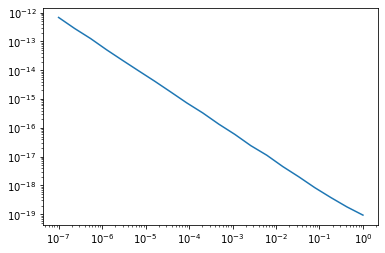

In [33]:
# -- Eeps --
#Two random vectors with same amplitude
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))

ntest=20
tests = np.logspace(-7,0,ntest)
Dua = Du_Eeps(a,p)
real = []
approx = []
for t in tests:
    real.append(Du_Eeps(a+t*a2,p))
    approx.append(Dua+t*Du2_Eeps(a,p,a2))

print(np.linalg.norm(Dua))
plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

61.071417492747855


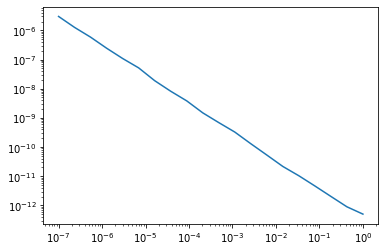

In [34]:
# -- Edata --
#Two random vectors with same amplitude
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))

ntest=20
tests = np.logspace(-7,0,ntest)
real = []
approx = []
Dua = Du_Edata(a,radial_p)
for t in tests:
    real.append(Du_Edata(a+t*a2,radial_p))
    approx.append(Dua+Du2_Edata(a,radial_p,t*a2))

print(np.linalg.norm(Dua))
plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

5.017689248777346e-05


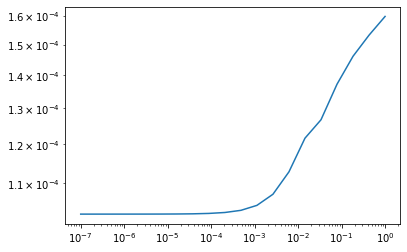

In [76]:
# -- Ereg --
#Two random vectors with same amplitude
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n

ntest=20
tests = np.logspace(-7,0,ntest)
real = []
approx = []
Dua = Du_Ereg(a,radial_p)
for t in tests:
    real.append(Du_Ereg(a+t*a2,radial_p))
    approx.append(Dua+Du2_Ereg(a,radial_p,t*a2))

print(np.linalg.norm(Dua))
plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

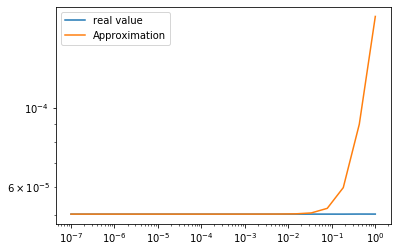

In [77]:
plt.plot(tests,np.array([np.linalg.norm(x) for x in real]),label="real value")
plt.plot(tests,np.array([np.linalg.norm(x) for x in approx]),label="Approximation")
plt.yscale("log")
plt.xscale("log")
plt.legend()

5.0674244741078616e-05


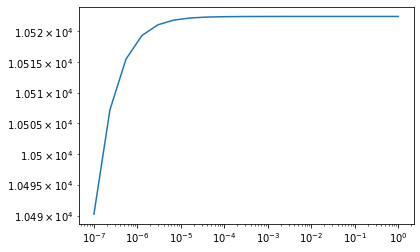

In [37]:
# -- Etot --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a=u0_mat
a2 = np.random.randn(n**2).reshape((n,n))

ntest=20
tests = np.logspace(-7,0,ntest)
real = []
approx = []
for t in tests:
    real.append(Du_Etot(a+t*a2,p))
    approx.append(Du_Etot(a,p)+Du2_Etot(a,p,t*a2))

print(np.linalg.norm(Du_Etot(a,p)))
plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

## Cross derivatives

In [59]:
def Dpu_Edata(u,p,w):
    Fu = fourier_op.op(u)-y
    Fw = fourier_op.op(w)
    return 2*p[:-1]*(np.real(Fu)*np.real(Fw)+np.imag(Fu)*np.imag(Fw))
def Dpu_Ereg(u,p,w):
    return p[-1]*np.sum(np.comp(w)*linear_op.adj_op(phi_vec(linear_op.op(u),param["gamma"])*linear_op.op(u)))

def Dpu_Etot(u,p,w):
    g = np.zeros((n**2+1,))
    g[:-1] = Dpu_Edata(u,p,w)
    #Don't learn alpha for the moment
    g[-1] = 0
    return g

## Loss function and penalty

In [78]:
c = 1e0
def L(u,u2):return c*np.linalg.norm(u-u2)**2
def grad_L(u,u2):return 2*c*(u-u2)

beta = 1e-11*c
def P(p):return beta*np.linalg.norm(p[:-1])**2
def grad_P(p):
    Dp = 2*beta*p
    Dp[-1] = 0
    return Dp

def P(p):return beta*np.sum(p[:-1]*(2-p[:-1]))
def grad_P(p):
    Dp = np.zeros(n**2+1)
    Dp[:-1] = 2*beta*(1-p[:-1])
    return Dp

In [79]:
param["pn1"]=1e-6
p = np.copy(radial_p)
uk,norms,energy = pdhg(y,p[:-1],fourier_op,linear_op,param,maxit=20,verbose=0)
print(f"\nL(u(p))={L(uk,u0_mat)}\nP(p)={P(p)}")

Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.21888232231140137 seconds.

L(u(p))=7.751848794032003e-10
P(p)=1.8789999999999998e-08


# Upper level energy

In [80]:
uk = np.zeros(u0_mat.shape)

def E(pk):
    global uk
    print("\nEvaluating E(p)")
    param["pn1"]=pk[-1]
    uk,norms = pdhg(y,pk[:-1],fourier_op,linear_op,param,compute_energy=False,maxit=20,verbose=0)
    return L(uk,u0_mat)+P(pk)

cgconv = []
def grad_E(pk,max_cgiter=1000,tol=1e-8,compute_conv=False):
    global uk,cgconv
    #Update alpha(p)
    param["pn1"]=pk[-1]
    
    print("\nStarting PDHG")
    uk,norms = pdhg(y,pk[:-1],fourier_op,linear_op,param,compute_energy=False,maxit=30,verbose=0)
    
    def mv(w):
        w = np.reshape(w,(n,n))
        return np.reshape(Du2_Etot(uk,pk,w),(n**2,))
    
    
    # -- Use cg to compute gradient --
    lin = LinearOperator((n**2,n**2),matvec=mv)
    B = np.reshape(np.conj(grad_L(uk,u0_mat)),(n**2,))
    def cgcall(x):
        if compute_conv:cgconv.append(np.linalg.norm(lin(x)-B)/np.linalg.norm(B))
    
    t1=time.time()
    print("\nStarting Conjugate Gradient method")
    x_inter,convergence = cg(lin,B,tol=tol,maxiter=max_cgiter,callback=cgcall)
    print(f"Finished in {time.time()-t1}s - ||Ax-b||/||b||: {np.linalg.norm(lin(x_inter)-B)/np.linalg.norm(B)}")
    return Dpu_Etot(uk,pk,np.reshape(x_inter,(n,n)))+grad_P(pk)

# Callback function
niter = 0
def fcall(x):
    global uk,niter
    niter += 1
    print("\033[1m" + f"\n{niter} iterations: ssim={ssim(uk,u0_mat)}\n\n" + "\033[0m")

In [81]:
p0 = 0.9*radial_p+0.1*np.random.rand(n**2+1)
p0[-1]=1e-6
Ep0,gradEp0 = E(p0),grad_E(p0)
p1 = np.random.rand(n**2+1)

tests = np.logspace(-9,0,30)
real_values = np.array([E(p0+t*p1) for t in tests])
approx = np.array([Ep0+t*np.sum(gradEp0*p1) for t in tests])


Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.15583157539367676 seconds.

Starting PDHG
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.1998307704925537 seconds.

Starting Conjugate Gradient method
Finished in 7.1727330684661865s - ||Ax-b||/||b||: 0.27753894424184794

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.12112689018249512 seconds.

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.16063880920410156 seconds.

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.12112212181091309 seconds.

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.1354382038116455 seconds.

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.12092351913452148 seconds.

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.13086676597595215 seconds.

Evaluating E(p)
Sigma: 0.44721359


Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.14446616172790527 seconds.
2.0211236952940207e-08


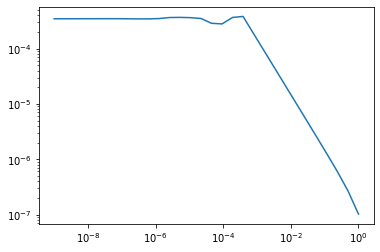

In [82]:
print(E(p0))
plt.plot(tests,abs((real_values-approx)/tests))
plt.xscale("log")
plt.yscale("log")

In [84]:
p[-1]=1e-6
gP = grad_E(radial_p,max_cgiter=3000,tol=1e-10,compute_conv=True)


Starting PDHG
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.22956347465515137 seconds.

Starting Conjugate Gradient method
Finished in 45.032808780670166s - ||Ax-b||/||b||: 0.07983097722999115


Text(0, 0.5, '||Ax-b||/||b||')

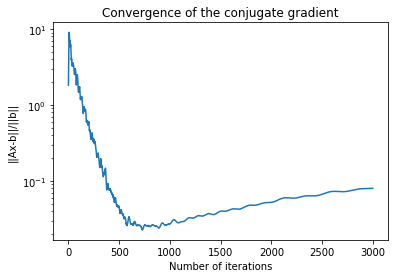

In [85]:
plt.plot(cgconv)
plt.yscale("log")
plt.title("Convergence of the conjugate gradient")
plt.xlabel("Number of iterations")
plt.ylabel("||Ax-b||/||b||")
#plt.savefig("Upper Level/CG_conv.png")

In [86]:
np.amax(gP)

5.106022622093054e-11

# L-BFGS-B

In [87]:
p0 = 0.9*p+0.1*np.random.rand(n**2+1)
# p0 = np.random.rand(n**2+1)
# p0=np.ones(n**2+1)
p0[-1] = 1e-6

In [93]:
niter = 0
pf,Emin,info = fmin_l_bfgs_b(E,p0,grad_E,bounds=[(0,1)]*n**2+[(0,np.inf)],pgtol=1e-15,
                           maxfun=1000,maxiter=1000,
                            callback = fcall)


Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.15352463722229004 seconds.

Starting PDHG
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.20481300354003906 seconds.

Starting Conjugate Gradient method
Finished in 7.0677900314331055s - ||Ax-b||/||b||: 2.2688160624806

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.11770319938659668 seconds.

Starting PDHG
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.22371673583984375 seconds.

Starting Conjugate Gradient method
Finished in 7.183601379394531s - ||Ax-b||/||b||: 2.2688160715133154

1 iterations: ssim=0.9259907054365649




In [94]:
print(E(p0),E(pf))


Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.14522433280944824 seconds.

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.13728666305541992 seconds.
2.023342147588628e-08 2.02334214756717e-08


In [95]:
print(pf[-1])
pysap.Image(data=np.reshape(p0[:-1]-pf[:-1],(n,n))).show()

1e-06


In [96]:
np.sum(p0),np.sum(pf)

(1817.0829139984885, 1817.0829139837847)

Sigma: 0.4472135954999579 
Tau: 1.118033988749895
10  iterations:
Cost: 3.3388846510981776e-09 
Norm: 0.04227038262152637 

20  iterations:
Cost: 3.2985177468947222e-09 
Norm: 0.002861538105700542 

30  iterations:
Cost: 3.2963825745761375e-09 
Norm: 0.0007402123997088788 

40  iterations:
Cost: 3.2961340210915897e-09 
Norm: 0.0004898522176367676 

50  iterations:
Cost: 3.2961183856879973e-09 
Norm: 0.0004336489924865564 

60  iterations:
Cost: 3.296118798097257e-09 
Norm: 0.0003636482006864322 

70  iterations:
Cost: 3.2961242995551457e-09 
Norm: 0.00022369329254972307 

80  iterations:
Cost: 3.2961259376821167e-09 
Norm: 0.00019722638708378318 

90  iterations:
Cost: 3.2961259397312407e-09 
Norm: 0.0001899019704274946 

100  iterations:
Cost: 3.2961251662005523e-09 
Norm: 0.00018708274338026791 

Finished in 0.9759185314178467 seconds.
0.9259355787507637


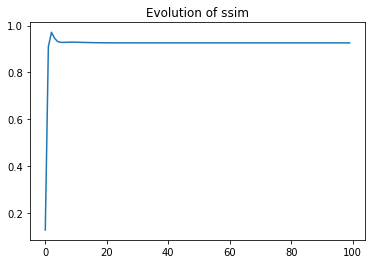

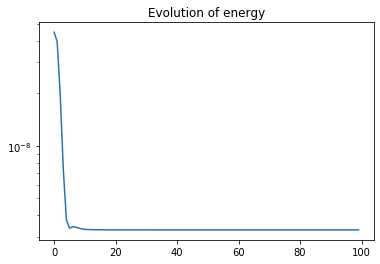

In [97]:
uk,norms,energy,ssims = pdhg(y,pf[:-1],fourier_op,linear_op,param,ground_truth=u0_mat,maxit=100)
print(ssim(uk,u0_mat))

plt.figure()
plt.plot(ssims)
plt.title("Evolution of ssim")
plt.show()

plt.figure()
plt.plot(energy)
plt.title("Evolution of energy")
plt.yscale("log")
plt.show()

pysap.Image(data=uk).show()